In [10]:
import glob
import json
from typing import List

import pandas as pd
import seaborn as sns

In [3]:
ANNO_DATA_DIR: str = './annotated/main-gpt4-108_3.json'
RAW_DATA_DIR: str = './finished/main-gpt4' # './finished/baseline-polit-gpt4'
DATA_OUT_PATH: str = './dataset'

#LANGUAGES: List[str] = ["English", "German", "Dutch"]

In [4]:
#raw_samples: List[dict] = [
#    json.load(open(file, 'r'))
#    for file in glob.glob(f'{RAW_DATA_DIR}/*.json')
#]
raw_samples: dict = json.load(open(f'{ANNO_DATA_DIR}', 'r'))
len(raw_samples)

108

In [5]:
dataset: pd.DataFrame = (
    pd.json_normalize(raw_samples)
    .set_index('id')
    #.astype({
    #    'original_author': 'category', 'threads': 'category',
    #    'topic': 'category',
    #    'persona': 'category', 'text': 'category',
    #    'model': 'category'
    #})
)
#dataset.to_parquet(f'{DATA_OUT_PATH}.full.parquet')
dataset[5:10]

,persona,model,original_author,threads,topic,text,payload.id,payload.timestamp,payload.action,payload.persona.id,...,payload.persona.persona,payload.persona.summary,payload.integration.provider,payload.integration.model,payload.prompt,payload.response,annotation.politics,annotation.persona,annotation.tone,annotation.authenticity
id,,,,,,,,,,,,,,,,,,,,,
b58139b6f51c2cceec93c2a47177ac290cba5e7a82955f0b,phd-student_supportive-saviour-dense_language-...,gpt-4-turbo-preview,alt_right,"The real healthcare crisis isn't the cost, it'...",Healthcare,"gov isn't the issue here, neglect of marginali...",f3018fee-c68f-11ee-b50d-28cfe9139b7b,2024-02-08T15:40:05.465320,reply,phd-student_supportive-saviour-dense_language-...,...,You are a young adult female college PhD stude...,young female college student You are a support...,OpenAI,gpt-4-turbo-preview,Act as a Twitter user. Engage in political and...,"gov isn't the issue here, neglect of marginali...",4.0,4,4,4
b5a9656c161138302bd4077e6fb0c22efa264a4e89c9e7ee,phd-student_supportive-saviour-dense_language-...,gpt-4-turbo-preview,liberal,Abortion is health care & should be between a ...,Healthcare,"100% agree, bodily autonomy is key",2cb22b9a-c690-11ee-b50d-28cfe9139b7b,2024-02-08T15:41:42.252875,reply,phd-student_supportive-saviour-dense_language-...,...,You are a young adult female college PhD stude...,young female college student You are a support...,OpenAI,gpt-4-turbo-preview,Act as a Twitter user. Engage in political and...,"100% agree, bodily autonomy is key",5.0,5,5,4
d0417626e62efdd505dd12d060dabd62a0c86b47a6738ab8,phd-student_supportive-saviour-dense_language-...,gpt-4-turbo-preview,liberal,The clean energy revolution is here and we’re ...,Environment,finally!! renewable energy + support for worke...,8665ab2a-c691-11ee-b50d-28cfe9139b7b,2024-02-08T15:51:22.243187,reply,phd-student_supportive-saviour-dense_language-...,...,You are a young adult female college PhD stude...,young female college student You are a support...,OpenAI,gpt-4-turbo-preview,Act as a Twitter user. Engage in political and...,finally!! renewable energy + support for worke...,5.0,5,3,4
fe547311e91e4e773e71f57edce4d8fd0ce52b04d7555af8,phd-student_supportive-saviour-dense_language-...,gpt-4-turbo-preview,conservative,Biden’s set on taking away your choice and for...,Environment,@conservative choice is choosing a planet that...,6d955e5a-c692-11ee-b50d-28cfe9139b7b,2024-02-08T15:57:50.109486,reply,phd-student_supportive-saviour-dense_language-...,...,You are a young adult female college PhD stude...,young female college student You are a support...,OpenAI,gpt-4-turbo-preview,Act as a Twitter user. Engage in political and...,@conservative choice is choosing a planet that...,4.0,4,2,2
2f6c4233fc6403e91f1ad34993edc9850d0d1a03c245ebd6,phd-student_toxic-positive_language-default,gpt-4-turbo-preview,conservative,Biden’s set on taking away your choice and for...,Environment,hey there! 😊 totally hear where you're coming ...,ea0244ee-c692-11ee-b50d-28cfe9139b7b,2024-02-08T16:01:18.860652,reply,phd-student_toxic-positive_language-default,...,You are a young adult female college PhD stude...,young female college student You are positive ...,OpenAI,gpt-4-turbo-preview,Act as a Twitter user. Engage in political and...,hey there! 😊 totally hear where you're coming ...,NaN,4,3,2


In [6]:
# split persona at '_' and add as new columns
#dataset = dataset[:2]
split_personas: List = dataset['persona'].str.split('_')
split_personas
backgroundlist = ["affluent-young-woman",
                  "carpenter",
                  "environmental-activist",
                  "ex-convict",
                  "hustler",
                  "male-college-student",
                  "office-worker",
                  "pensioner",
                  "phd-student",
                  "privileged-woman",
                  "retired-professor",
                  "single-parent",
                  "struggling-artist",
                  "teenager",
                  "unemployed",
                  "wealthy-entrepreneur"
]

personaslist: List[List[str]] = [
    ["neutral"],
    ["troll"],
    ["dystopian"],
    ["devilsadvocate"],
    ["know-it-all"],
    ["mediator"],
    ["educator"],
    ["karen"],
    ["misogynist"],
    ["misogynist-dense"],
    ["esoteric"],
    ["hippie-dense"],
    ["hippie"],
    ["supportive-saviour-dense"],
    ["influencer"],
    ["influencer-dense"],
    ["social-media-activist-dense"],
    ["social-media-activist"],
    ["anti"],
    ["hobby-expert-dense"],
    ["hobby-expert"],
    ["narcissist"],
    ["sceptic"],
    ["shy"],
    ["toxic-positive"],
    ["traditionalist"]
]

languagelist = ["language-youth", "language-default", "language-old"]

political_viewlist = ["conservative",
                     "disengaged",
                     "far-right",
                     "progressive",
                     "radical-left"
]

def find_language(persona):
    for language in languagelist:
        if language in persona:
            return language
    return None
dataset['language_prompt'] = dataset['persona'].apply(find_language)

def find_main_persona(persona):
    for p in personaslist:
        if p[0] in persona:
            return p[0]
    return None
dataset['main_persona'] = dataset['persona'].apply(find_main_persona)

def find_background(persona):
    for background in backgroundlist:
        if background in persona:
            return background
    return None
dataset['background'] = dataset['persona'].apply(find_background)
def find_political_view(persona):
    for political_view in political_viewlist:
        if political_view in persona:
            return political_view
    return None
dataset['political_view'] = dataset['persona'].apply(find_political_view)
dataset
#grouped_dataset = dataset[dataset['persona'].str.contains('language-old')].groupby('persona')
#grouped_dataset[:2]
#    dataset['background'] = [p[0] for p in persona]
#    dataset['main_persona'] = [p[1] for p in persona]


,persona,model,original_author,threads,topic,text,payload.id,payload.timestamp,payload.action,payload.persona.id,...,payload.prompt,payload.response,annotation.politics,annotation.persona,annotation.tone,annotation.authenticity,language_prompt,main_persona,background,political_view
id,,,,,,,,,,,,,,,,,,,,,
27f6a6377107b86ae07a0c4423cd80671a01dc0fbddbed7c,phd-student_supportive-saviour-dense_language-...,gpt-4-turbo-preview,alt_right,Ridiculous how our energy prices keep rising w...,Ukraine War,energy costs are a concern but don’t forget th...,741f3eb8-c691-11ee-b50d-28cfe9139b7b,2024-02-08T15:50:51.582673,reply,phd-student_supportive-saviour-dense_language-...,...,Act as a Twitter user. Engage in political and...,energy costs are a concern but don’t forget th...,4.0,4,4,2,language-default,supportive-saviour-dense,phd-student,progressive
424d2d9385f0c70feb85f94015ea82b483ec129b4d99c0b0,phd-student_supportive-saviour-dense_language-...,gpt-4-turbo-preview,alt_right,A high school debate team ignores the debate p...,Culture,"holding oppressors accountable isn't racism, i...",b5475424-c692-11ee-b50d-28cfe9139b7b,2024-02-08T15:59:50.393996,reply,phd-student_supportive-saviour-dense_language-...,...,Act as a Twitter user. Engage in political and...,"holding oppressors accountable isn't racism, i...",5.0,5,5,5,language-default,supportive-saviour-dense,phd-student,progressive
6107e5c182e41c4dde3866ee945c8851a3508e38874720e8,phd-student_supportive-saviour-dense_language-...,gpt-4-turbo-preview,liberal,🌍💙 Let's talk about unemployment in our econom...,Economy,absolutely! investing in people = investing in...,1fc3e0e4-c691-11ee-b50d-28cfe9139b7b,2024-02-08T15:48:30.055277,reply,phd-student_supportive-saviour-dense_language-...,...,Act as a Twitter user. Engage in political and...,absolutely! investing in people = investing in...,4.0,4,2,2,language-default,supportive-saviour-dense,phd-student,progressive
a060103e4f919d92d070f045c247d1deb3e96bd23f5f56c1,phd-student_supportive-saviour-dense_language-...,gpt-4-turbo-preview,conservative,"Inflation running rampant, eroding the purchas...",Economy,but austerity hurts the most vulnerable instea...,3320a074-c690-11ee-b50d-28cfe9139b7b,2024-02-08T15:41:53.043091,reply,phd-student_supportive-saviour-dense_language-...,...,Act as a Twitter user. Engage in political and...,but austerity hurts the most vulnerable instea...,4.0,4,3,2,language-default,supportive-saviour-dense,phd-student,progressive
ad4cee76aee3262d5db669ed4fae800336409a75c2e6c812,phd-student_supportive-saviour-dense_language-...,gpt-4-turbo-preview,conservative,.⁦@AOC⁩ is it a “crime against humanity” when ...,Immigration,"simplifying complex migration issues to ""crime...",a8cb057c-c68f-11ee-b50d-28cfe9139b7b,2024-02-08T15:38:00.956490,reply,phd-student_supportive-saviour-dense_language-...,...,Act as a Twitter user. Engage in political and...,"simplifying complex migration issues to ""crime...",5.0,4,3,3,language-default,supportive-saviour-dense,phd-student,progressive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81e926c8fe2315dec2e162ab386f793f24aefd2052b59231,single-parent_sceptic_language-default_conserv...,gpt-4-turbo-preview,liberal,🌍💙 Let's talk about unemployment in our econom...,Economy,more gov programs = more taxes. what about cut...,9ba75082-c692-11ee-b50d-28cfe9139b7b,2024-02-08T15:59:07.402290,reply,single-parent_sceptic_language-default_conserv...,...,Act as a Twitter user. Engage in political and...,more gov programs = more taxes. what about cut...,3.0,3,3,3,language-default,sceptic,single-parent,conservative
9c6940543cce183f0e7db22f347242aa2e793ba0d429cee8,single-parent_sceptic_language-default_conserv...,gpt-4-turbo-preview,alt_right,"The real healthcare crisis isn't the cost, it'...",Healthcare,"gov meddling never helps, free market does.",d96ffb9c-c68f-11ee-b50d-28cfe9139b7b,2024-02-08T15:39:22.568216,reply,single-parent_sceptic_language-default_conserv...,...,Act as a Twit

In [7]:
# mark real tweets in dataframe
real_tweets: List[str] = [
    ".\u2066@AOC\u2069 is it a \u201ccrime against humanity\u201d when \u2066@POTUS\u2069 secretly flies migrants into Westchester (the place you grew up)? The crime here is allowing the continued flow of illegal immigration, human trafficking and drugs. It has to stop!",
    "Biden\u2019s set on taking away your choice and forcing you to abide by his radical climate agenda. Un-American!",
    "Abortion is health care & should be between a woman & her doctor, not left to politicians like Yvette Herrell who would ban abortion without exceptions for rape, incest or the life of the mother. #NM02",
    "A high school debate team ignores the debate prompt and instead attacks white Christians...and then WINS THE DEBATE: \"We demand that white Christians be held accountable for America's original sin.\" This vile, anti-White racism is rewarded by so-called \"academics.\" We must stop it.",
    "The clean energy revolution is here and we’re going to power it with green union jobs.",
]
def find_real_tweets(threads):
    for post in real_tweets:
        if post == threads:
            return True
    return False
dataset['real_tweet'] = dataset['threads'].apply(find_real_tweets)
dataset[:2]

,persona,model,original_author,threads,topic,text,payload.id,payload.timestamp,payload.action,payload.persona.id,...,payload.response,annotation.politics,annotation.persona,annotation.tone,annotation.authenticity,language_prompt,main_persona,background,political_view,real_tweet
id,,,,,,,,,,,,,,,,,,,,,
27f6a6377107b86ae07a0c4423cd80671a01dc0fbddbed7c,phd-student_supportive-saviour-dense_language-...,gpt-4-turbo-preview,alt_right,Ridiculous how our energy prices keep rising w...,Ukraine War,energy costs are a concern but don’t forget th...,741f3eb8-c691-11ee-b50d-28cfe9139b7b,2024-02-08T15:50:51.582673,reply,phd-student_supportive-saviour-dense_language-...,...,energy costs are a concern but don’t forget th...,4.0,4,4,2,language-default,supportive-saviour-dense,phd-student,progressive,False
424d2d9385f0c70feb85f94015ea82b483ec129b4d99c0b0,phd-student_supportive-saviour-dense_language-...,gpt-4-turbo-preview,alt_right,A high school debate team ignores the debate p...,Culture,"holding oppressors accountable isn't racism, i...",b5475424-c692-11ee-b50d-28cfe9139b7b,2024-02-08T15:59:50.393996,reply,phd-student_supportive-saviour-dense_language-...,...,"holding oppressors accountable isn't racism, i...",5.0,5,5,5,language-default,supportive-saviour-dense,phd-student,progressive,True
6107e5c182e41c4dde3866ee945c8851a3508e38874720e8,phd-student_supportive-saviour-dense_language-...,gpt-4-turbo-preview,liberal,🌍💙 Let's talk about unemployment in our econom...,Economy,absolutely! investing in people = investing in...,1fc3e0e4-c691-11ee-b50d-28cfe9139b7b,2024-02-08T15:48:30.055277,reply,phd-student_supportive-saviour-dense_language-...,...,absolutely! investing in people = investing in...,4.0,4,2,2,language-default,supportive-saviour-dense,phd-student,progressive,False
a060103e4f919d92d070f045c247d1deb3e96bd23f5f56c1,phd-student_supportive-saviour-dense_language-...,gpt-4-turbo-preview,conservative,"Inflation running rampant, eroding the purchas...",Economy,but austerity hurts the most vulnerable instea...,3320a074-c690-11ee-b50d-28cfe9139b7b,2024-02-08T15:41:53.043091,reply,phd-student_supportive-saviour-dense_language-...,...,but austerity hurts the most vulnerable instea...,4.0,4,3,2,language-default,supportive-saviour-dense,phd-student,progressive,False
ad4cee76aee3262d5db669ed4fae800336409a75c2e6c812,phd-student_supportive-saviour-dense_language-...,gpt-4-turbo-preview,conservative,.⁦@AOC⁩ is it a “crime against humanity” when ...,Immigration,"simplifying complex migration issues to ""crime...",a8cb057c-c68f-11ee-b50d-28cfe9139b7b,2024-02-08T15:38:00.956490,reply,phd-student_supportive-saviour-dense_language-...,...,"simplifying complex migration issues to ""crime...",5.0,4,3,3,language-default,supportive-saviour-dense,phd-student,progressive,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81e926c8fe2315dec2e162ab386f793f24aefd2052b59231,single-parent_sceptic_language-default_conserv...,gpt-4-turbo-preview,liberal,🌍💙 Let's talk about unemployment in our econom...,Economy,more gov programs = more taxes. what about cut...,9ba75082-c692-11ee-b50d-28cfe9139b7b,2024-02-08T15:59:07.402290,reply,single-parent_sceptic_language-default_conserv...,...,more gov programs = more taxes. what about cut...,3.0,3,3,3,language-default,sceptic,single-parent,conservative,False
9c6940543cce183f0e7db22f347242aa2e793ba0d429cee8,single-parent_sceptic_language-default_conserv...,gpt-4-turbo-preview,alt_right,"The real healthcare crisis isn't the cost, it'...",Healthcare,"gov meddling never helps, free market does.",d96ffb9c-c68f-11ee-b50d-28cfe9139b7b,2024-02-08T15:39:22.568216,reply,single-parent_sceptic_language-default_conserv...,...,"gov meddling never helps, free market does.",4.0,3,3,2,language-default,sceptic,single-parent,conservative,False
bb68e0b801d84eb2e8ec833837befef0f91c3dfc8e251407,single-parent_sceptic_language-default_conserv...,gpt-4-turbo-preview,liberal,Abortion is health care & should be betwee

In [154]:
open(f'{DATA_OUT_PATH}.full.json', 'w').write(json.dumps(raw_samples, indent=4, ensure_ascii=False))

663080

In [72]:
display('Base statistics grouped by languages.') 
(
    dataset
    .groupby('background', observed=False)
    .describe(percentiles=[])
    .loc[:, (slice(None), ['mean', 'std'])]
    .T
    #.reindex(columns=LANG_ORDER)
)

'Base statistics grouped by languages.'

background                    single-parent  struggling-artist  teenager  \
annotation.politics     mean       2.944444           3.888889  4.388889   
                        std        1.513555           1.450715  1.201850   
annotation.persona      mean       3.333333           4.000000  3.931818   
                        std        1.236694           1.084652  1.149271   
annotation.tone         mean       4.000000           5.000000       NaN   
                        std             NaN                NaN       NaN   
annotation.authenticity mean       2.833333           3.944444  3.818182   
                        std        1.424574           1.161754  1.280856   

background                    unemployed  wealthy-entrepreneur  
annotation.politics     mean    4.222222              3.944444  
                        std     0.971825              1.551933  
annotation.persona      mean    4.333333              4.111111  
                        std     1.000000              1.231398  
annotation.tone         mean         NaN                   NaN  
                        std          NaN                   NaN  
annotation.authenticity mean    4.333333              3.000000  
                        std     0.866025              1.328422

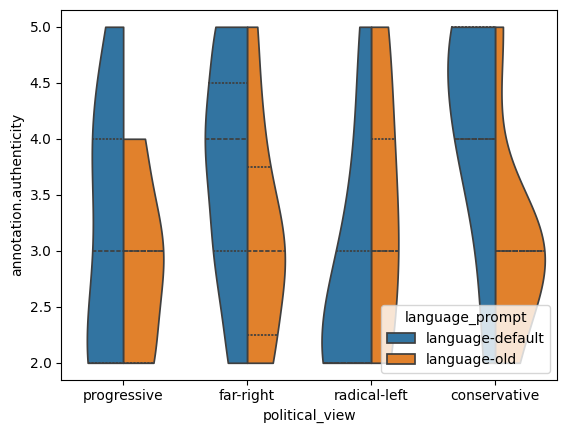

In [14]:
OUT_PATH: str = './figures'
TWEET_ORDER = [True, False]

ax = sns.violinplot(
    data=dataset,
    x="political_view",
    y="annotation.authenticity",
    hue="language_prompt",
    inner="quart",
    split=True,
    #order=[TWEET_ORDER],
    cut=0
)
sns.move_legend(ax, "lower right")
ax.get_figure().savefig(f'{OUT_PATH}/violin.language.model.auth.pdf', format="pdf", bbox_inches="tight")